In [1]:
# cd("/home/xinhou/radPV")
include("helper.jl");

In [2]:
path1 = joinpath(myPath, vars[end], ssps[1], "day/EU/tilt_lat/regr")
rmcp(path1)
fn = joinpath(path1, readdir(path1)[1])
lon = ncread(fn, "lon")
lat = ncread(fn, "lat");

In [3]:
function getArr(var, s, m) # get array by variable, ssp, model
    path = joinpath(myPath, var, ssps[s], "day/EU/tilt_lat/regr")
    rmcp(path)
    fn = joinpath(path, readdir(path)[m])
    arr = ncread(fn, var)
    return arr
end

getArr (generic function with 1 method)

In [4]:
function getCh(var, m) # 20yrx365d time series of 1-model change 
    varH = getArr(var, 1, m)
    var1 = getArr(var, 2, m)
    var5 = getArr(var, 5, m)
    pvh, pv1, pv5 = avg.([varH, var1, var5])
    
    pv1ch = pv1 .- pvh
    pv1chPer = pv1ch ./ pvh * 100
    pv5ch = pv5 .- pvh
    pv5chPer = pv5ch ./ pvh * 100

    return pv1ch, pv5ch, pv1chPer, pv5chPer
end

getCh (generic function with 1 method)

In [5]:
function getMult() # multi-model mean
    var = "pv"
    len = 28
    pv1ch = zeros(16,16,len)
    pv5ch = zeros(16,16,len)
    pv1chPer = zeros(16,16,len)
    pv5chPer = zeros(16,16,len)
    for m in 1:len
        println(m)
        pv1ch[:,:,m], pv5ch[:,:,m], pv1chPer[:,:,m], pv5chPer[:,:,m] = getCh(var, m)
    end
    return pv1ch, pv5ch, pv1chPer, pv5chPer
end

getMult (generic function with 1 method)

### Change

In [6]:
pvCh = avg.(getMult())
pvAgr = agreeDots.(getMult());

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [7]:
tlts = ["ssp1 absolute", "ssp5 absolute", 
        "ssp1 relative", "ssp5 relative"];

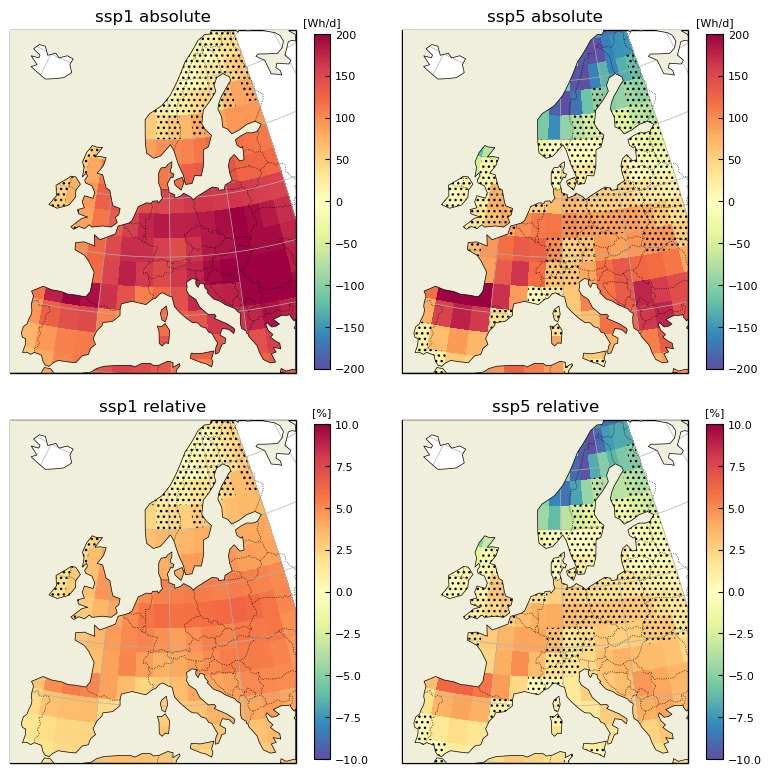

In [8]:
fig = plt.figure(figsize=(8,8))
for i=1:4
    ax = plt.subplot(2,2,i, projection=proj3)
    title(tlts[i])
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":")     
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"]) 
    wrap_data, wrap_lon = cput.add_cyclic_point(pvCh[i]', coord=lon, axis=1)
    wrap_agr, wrap_lon = cput.add_cyclic_point(pvAgr[i], coord=lon, axis=1) 
    i <= 2 ?
        (vmin, vmax, unit) = (-200, 200, "[Wh/d]") :
        (vmin, vmax, unit) = (-10, 10, "[%]")
    p = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="Spectral_r", vmin=vmin, vmax=vmax) 
    ax.pcolor(wrap_lon, lat, wrap_agr, transform=proj1, alpha=0., hatch="...") 
    
    cbar = plt.colorbar(p, shrink=0.92) 
    cbar.ax.set_title(unit, size=8)
    cbar.ax.tick_params(direction="in", labelsize=8)
end
plt.tight_layout()

In [9]:
function pvSeas1grid(pvGr) # 20-yr series of 1 grid
    pv = getPvMatrix(pvGr) # convert to 365x20 matrix first
    
    if size(pv,1) == 365
        idxSum = 152:243
        idxWin = [1:59; 365-30:365]
    else # 358
        idxSum = 179:30*9-2
        idxWin = [1:58; 358-29:358]
    end    

    summ, wint = pv[idxSum,:], pv[idxWin,:]
    return mean(summ), mean(wint)
end

pvSeas1grid (generic function with 1 method)

In [10]:
function pvSeas1Mdl(pv) # in one model
    pvSumm = zeros(16,16)
    pvWint = zeros(16,16)
    for lat in 1:16, lon in 1:16
        pvSumm[lon, lat], pvWint[lon, lat] = pvSeas1grid(pv[lon,lat,:])
    end
    return pvSumm, pvWint
end

pvSeas1Mdl (generic function with 1 method)

In [11]:
function pvSeasAllMdl(s, pathPv)  # across all models
    pathPv = joinpath(myPath, "pv/" * ssps[s] * "/day/EU/regr/")
    rmcp(pathPv)

    pvSumm = zeros(16,16,28)
    pvWint = zeros(16,16,28)
    for m in 1:28
        println(m)
        fnam = joinpath(pathPv, readdir(pathPv)[m])
        
        pv = ncread(fnam, "pv") 
        pvSumm[:,:,m], pvWint[:,:,m] = pvSeas1Mdl(pv)
    end
    return pvSumm, pvWint
end

pvSeasAllMdl (generic function with 1 method)

In [12]:
function getMultSeason(op) # option: abs (0) or rel (1) change
    var = "pv"
    len = 28
    ch1sum = zeros(16,16,28)
    ch5sum = zeros(16,16,28)
    ch1win = zeros(16,16,28)
    ch5win = zeros(16,16,28)
    for m in 1:len
        println(m)
        pvh = getArr(var, 1, m)
        pv1 = getArr(var, 2, m)
        pv5 = getArr(var, 5, m)
        pvhSumm, pvhWint = pvSeas1Mdl(pvh)
        pv1Summ, pv1Wint = pvSeas1Mdl(pv1)
        pv5Summ, pv5Wint = pvSeas1Mdl(pv5)
        if op == 1
            ch1sum[:,:,m] = (pv1Summ .- pvhSumm) ./ pvhSumm * 100
            ch5sum[:,:,m] = (pv5Summ .- pvhSumm) ./ pvhSumm * 100
            ch1win[:,:,m] = (pv1Wint .- pvhWint) ./ pvhWint * 100
            ch5win[:,:,m] = (pv5Wint .- pvhWint) ./ pvhWint * 100               
        else
            ch1sum[:,:,m] = pv1Summ - pvhSumm
            ch5sum[:,:,m] = pv5Summ - pvhSumm
            ch1win[:,:,m] = pv1Wint - pvhWint
            ch5win[:,:,m] = pv5Wint - pvhWint
        end
    end
    return ch1sum, ch5sum, ch1win, ch5win
end

getMultSeason (generic function with 1 method)

### Absolute

In [13]:
pvChSeas = getMultSeason(0)
pvChSeasMn = avg.(pvChSeas)
pvChSeasAgr = agreeDots.(pvChSeas);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [14]:
tltsSeas = ["ssp1 summer", "ssp5 summer", 
            "ssp1 winter", "ssp5 winter"];

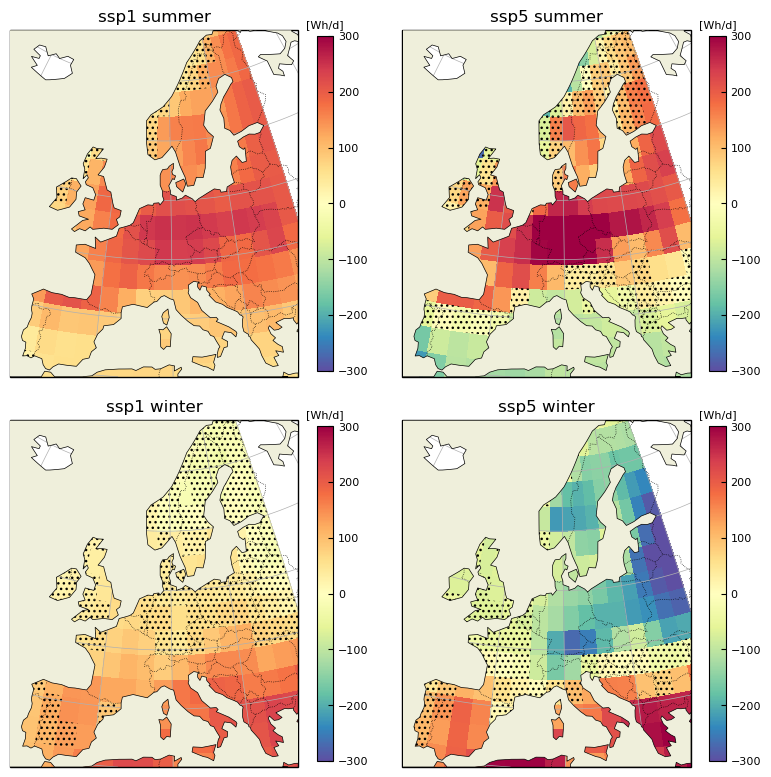

In [15]:
fig = plt.figure(figsize=(8,8))
for i=1:4
    ax = plt.subplot(2,2,i, projection=proj3)
    title(tltsSeas[i])
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":") 
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"])     
    wrap_data, wrap_lon = cput.add_cyclic_point(pvChSeasMn[i]', coord=lon, axis=1)
    wrap_agr, wrap_lon = cput.add_cyclic_point(pvChSeasAgr[i], coord=lon, axis=1)  
    p = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="Spectral_r", vmin=-300, vmax=300) 
    ax.pcolor(wrap_lon, lat, wrap_agr, transform=proj1, alpha=0., hatch="...") 

    cbar = plt.colorbar(p, shrink=0.92) 
    cbar.ax.set_title("[Wh/d]", size=8)
    cbar.ax.tick_params(direction="in", labelsize=8)
end
plt.tight_layout()

### Relative

In [16]:
pvChSeasPer = getMultSeason(1)
pvChSeasPerMn = avg.(pvChSeasPer)
pvChSeasPerAgr = agreeDots.(pvChSeasPer);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


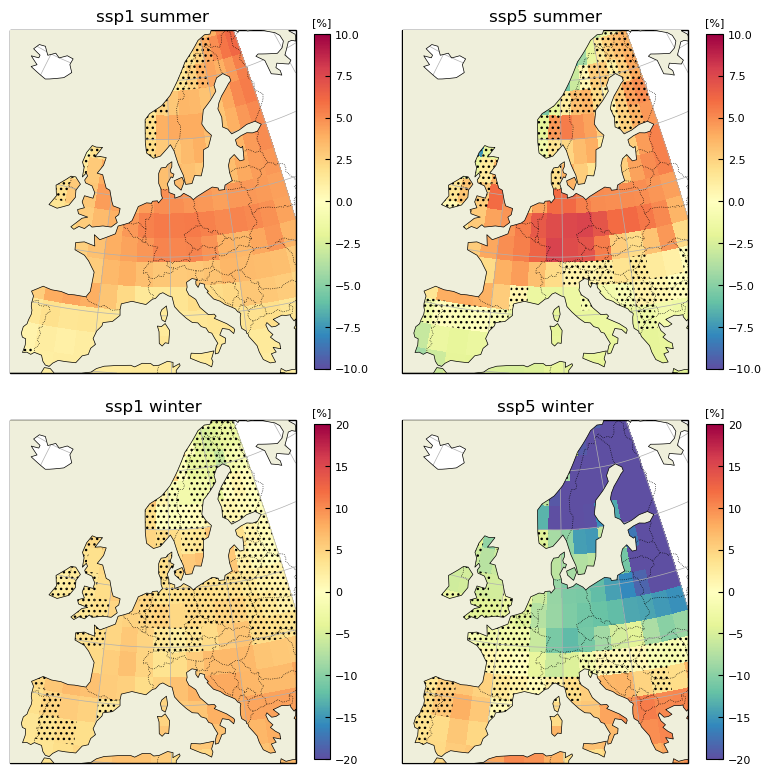

In [17]:
fig = plt.figure(figsize=(8,8))
for i=1:4
    ax = plt.subplot(2,2,i, projection=proj3)
    title(tltsSeas[i])
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":") 
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"])     
    wrap_data, wrap_lon = cput.add_cyclic_point(pvChSeasPerMn[i]', coord=lon, axis=1)
    wrap_agr, wrap_lon = cput.add_cyclic_point(pvChSeasPerAgr[i], coord=lon, axis=1)  
    i <= 2 ?
        (vmin,vmax) = (-10,10) : (vmin,vmax) = (-20,20)
    p = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="Spectral_r", vmin=vmin, vmax=vmax)
    ax.pcolor(wrap_lon, lat, wrap_agr, transform=proj1, alpha=0., hatch="...") 

    cbar = plt.colorbar(p, shrink=0.92) 
    cbar.ax.set_title("[%]", size=8)
    cbar.ax.tick_params(direction="in", labelsize=8)
end
plt.tight_layout()